# Room acoustic parameter estimation¶

### Author: Suradej Duangpummet

PhD candidate in SIIT-JAIST.

Under supervision of Prof. Massashi Unoki, Assoc.Prof.Waree, and Dr.Jessada.

Created Date: March 20, 2018
  
Updated: March 25, 2018 (test new feature :mcff)
     
Last Update: March 26, 2018 (RNN using tflearn,tensorflow)

In [8]:
from __future__ import division

import os
import sys
import re

import scipy as sp
import numpy as np 
import math
import matplotlib.pyplot as plt 
import librosa

from random import shuffle
from numpy import fft, cos, sin, pi, arange
from scipy.io import wavfile
from scipy.io.wavfile import write
from scipy.signal import butter, lfilter, freqz, kaiserord, firwin, hilbert, chirp

from scipy import fft, arange , signal
from matplotlib import gridspec

from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid,axes, show

import thinkdsp
import thinkplot
#----- Deep Learning using Recurrent Neural Network with LSTM ---------
import tflearn
import tensorflow as tf

%matplotlib inline

Scipy library to read audio file to 1-D Vector, Fs is Sampling rate (Sample/sec)

Room impulse response from SMILE dataset (txxxx.wav)

1-D vector of audio file like: [0 0 0 ... 0 0 0]
Sample rate: 44100


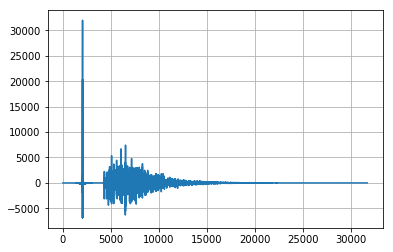

In [72]:
Fs,sound1 = wavfile.read('t20101.wav')
print("1-D vector of audio file like:",sound1)
print("Sample rate:",Fs)
plt.plot(sound1)
plt.grid(True)

Fourier Transfrom

/home/suradej/anaconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


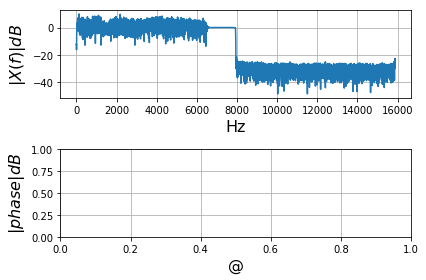

In [73]:
y = sound1
n = len(y) # length of the signal
k = arange(n)
T = n/Fs
frq = k/T # two sides frequency range

plt.subplot(2, 1, 1) #magnitude plot
Yw = np.fft.rfft(y)/n # fft computing and normalization
magdB = 10*np.log10(Yw/2)
plt.plot(magdB)
plt.grid()
plt.xlabel("Hz",fontsize=16)
plt.ylabel('$|X(f)| dB$',fontsize=16)
plt.tight_layout()

plt.subplot(2, 1, 2) #phase plot
plt.grid()
plt.xlabel("@",fontsize=16)
plt.ylabel('$|phase| dB$',fontsize=16)
plt.tight_layout()

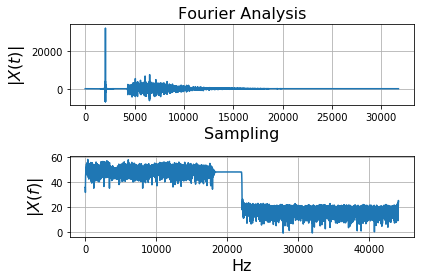

In [74]:
#Read Speech+Impulse Response signal (in WAV format with 16 bit depth)
Fs,sound1 = wavfile.read('t20101.wav')
x = sound1
rir_1 = x
n = arange(0,len(x),1)

#Fourier Transform
Xf = np.fft.rfft(x)
#Amplitude
AXf = 10*np.log10(np.abs(Xf))

#Time Domain plot
plt.subplot(2, 1, 1)
plt.plot(n,x)
plt.grid()
plt.xlabel("Sampling",fontsize=16)
plt.ylabel(r'$|X(t)|$',fontsize=16)
plt.title("Fourier Analysis",fontsize=16)

#Frequency Domain plot
plt.subplot(2, 1, 2)
plt.plot(np.linspace(0,Fs,len(Xf)),AXf)
plt.grid()
plt.xlabel("Hz",fontsize=16)
plt.ylabel('$|X(f)|$',fontsize=16)

plt.tight_layout()

## Butter FIR bandpass Filtert

In [75]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

freq upper 2828.42712474619
freq lower 1414.2135623730949


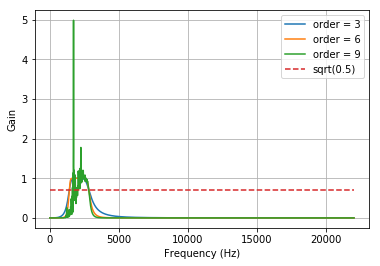

In [76]:
fcentre = 2000
fd = np.power(2,1/2)
highcut = fcentre *fd
lowcut = fcentre/fd
print("freq upper",highcut)
print("freq lower",lowcut)
# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, Fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((Fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * Fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

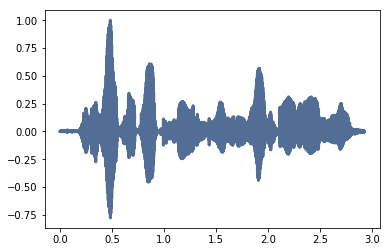

In [77]:
speech1 = thinkdsp.read_wave('TIMIT_Test_up441.wav')
speech1.normalize()
speech1.plot()
speech1.make_audio()

In [78]:
RIR = thinkdsp.read_wave('t20101.wav')
RIR.make_audio()

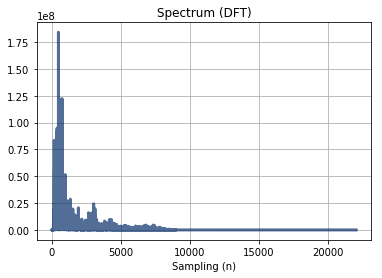

In [143]:
spec1 = speech1.make_spectrum()
grid(True)
plt.title('Spectrum (DFT)')
plt.xlabel('Sampling (n)')
plt.ylabel('')
spec1.plot()

## Convolution

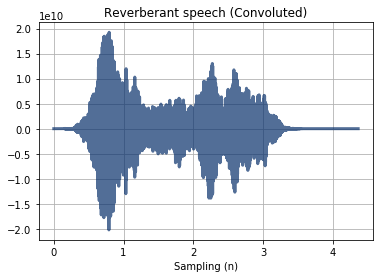

In [141]:
convolved_s1 = speech1.convolve(rir_1)
grid(True)
plt.title('Reverberant speech (Convoluted)')
plt.xlabel('Sampling (n)')
plt.ylabel('')
convolved_s1.plot()
convolved_s1.make_audio()

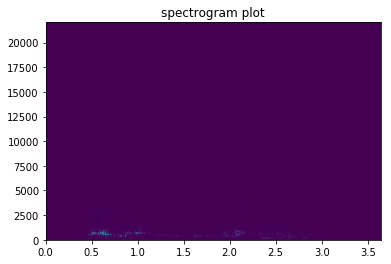

In [140]:
f,t,Sxx = sp.signal.spectrogram(speech1.ys,speech1.framerate)
plt.pcolormesh(t,f,Sxx)
plt.title('Spectrogram plot')
plt.show()

In [83]:
speech1= convolved_s1

# MTF Approch
## Seven-Octave bandpass filter bank

In [85]:
fcentre = 125
fd = np.power(2,1/2)
highcut = fcentre *fd
lowcut = fcentre/fd
Fs = speech1.framerate

b, a = butter_bandpass(lowcut, highcut, Fs, order=8)
y_f125 = sp.signal.filtfilt(b,a,speech1.ys)

In [86]:
fcentre = 250
fd = np.power(2,1/2)
highcut = fcentre *fd
lowcut = fcentre/fd
Fs = speech1.framerate

b, a = butter_bandpass(lowcut, highcut, Fs, order=8)
y_f250 = sp.signal.filtfilt(b,a,speech1.ys)

In [87]:
fcentre = 500
fd = np.power(2,1/2)
highcut = fcentre *fd
lowcut = fcentre/fd
Fs = speech1.framerate

b, a = butter_bandpass(lowcut, highcut, Fs, order=8)
y_f500 = sp.signal.filtfilt(b,a,speech1.ys)

In [88]:
fcentre = 1000
fd = np.power(2,1/2)
highcut = fcentre *fd
lowcut = fcentre/fd
Fs = speech1.framerate

b, a = butter_bandpass(lowcut, highcut, Fs, order=8)
y_f1k = sp.signal.filtfilt(b,a,speech1.ys)

In [89]:
fcentre = 2000
fd = np.power(2,1/2)
highcut = fcentre *fd
lowcut = fcentre/fd
Fs = speech1.framerate

b, a = butter_bandpass(lowcut, highcut, Fs, order=8)
y_f2k = sp.signal.filtfilt(b,a,speech1.ys)

In [90]:
fcentre = 4000
fd = np.power(2,1/2)
highcut = fcentre *fd
lowcut = fcentre/fd
Fs = speech1.framerate

b, a = butter_bandpass(lowcut, highcut, Fs, order=8)
y_f4k = sp.signal.filtfilt(b,a,speech1.ys)

In [91]:
fcentre = 8000
fd = np.power(2,1/2)
highcut = fcentre *fd
lowcut = fcentre/fd
Fs = speech1.framerate
b, a = butter_bandpass(lowcut, highcut, Fs, order=8)
y_f8k = sp.signal.filtfilt(b,a,speech1.ys)

## Envelope Extraction using Hilbert Transform

In [132]:
fc = 30 # cutoff frequency of the speech envelope  at 30 Hz
N = 9   #filter order
w_L = 2*fc/speech1.framerate
#lowpas filter tf
b, a = butter(N,w_L, 'low')

e_yt_1 = sp.signal.filtfilt(b,a,np.abs(hilbert(y_f125)))
e_yt_2 = sp.signal.filtfilt(b,a,np.abs(hilbert(y_f250)))
e_yt_3 = sp.signal.filtfilt(b,a,np.abs(hilbert(y_f500)))
e_yt_4 = sp.signal.filtfilt(b,a,np.abs(hilbert(y_f1k)))
e_yt_5 = sp.signal.filtfilt(b,a,np.abs(hilbert(y_f2k)))
e_yt_6 = sp.signal.filtfilt(b,a,np.abs(hilbert(y_f4k)))
e_yt_7 = sp.signal.filtfilt(b,a,np.abs(hilbert(y_f8k)))


plot some envelope

Text(0,0.5,'Gain')

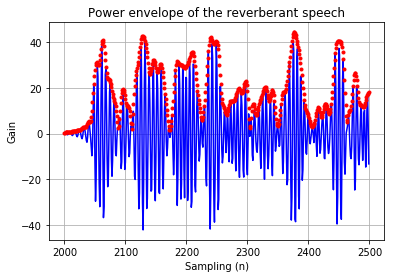

In [136]:
nn = arange(0,len(y_f8k),1)
n = nn[2000:2500]
env7_sl = env7[2000:2500]
figure(1)
plot(n, y_f8k[2000:2500],'b-', label='signal')
plt.plot(n,env7_sl,'r',marker = "o",ms=3,ls="")
grid(True)
plt.title('Power envelope of the reverberant speech')
plt.xlabel('Sampling (n)')
plt.ylabel('Gain')

# mfcc approch
## Mel-Frequency Ceptrum Coefficient 

In [144]:
mfcc_1 = librosa.feature.mfcc(convolved_s1.ys,convolved_s1.framerate,n_mfcc = 20)

In [146]:
mfcc_1

array([[ 1.79715773e+03,  1.79715773e+03,  1.79715773e+03, ...,
         1.79715773e+03,  1.79715773e+03,  1.79715773e+03],
       [-1.97334768e-14, -1.97334768e-14, -1.97334768e-14, ...,
        -1.97334768e-14, -1.97334768e-14, -1.97334768e-14],
       [-1.84612571e-13, -1.84612571e-13, -1.84612571e-13, ...,
        -1.84612571e-13, -5.13548256e-15, -5.13548256e-15],
       ...,
       [ 1.84741111e-13,  1.84741111e-13,  1.84741111e-13, ...,
         1.84741111e-13,  1.69149644e-13,  1.69149644e-13],
       [-6.38262276e-14, -6.38262276e-14, -6.38262276e-14, ...,
        -6.38262276e-14, -6.38262276e-14, -6.38262276e-14],
       [-1.13904885e-13, -1.13904885e-13, -1.13904885e-13, ...,
        -1.13904885e-13, -1.13904885e-13, -1.13904885e-13]])

## Test Singular Value Decompostion (SVD) 

In [96]:
a = [(5, 6, 2),(6, 1, 4),(2, 4, 7)]

In [97]:
U,s,V =  np.linalg.svd(a, full_matrices=True)

In [98]:
U

array([[-0.59228156,  0.61680524,  0.51841476],
       [-0.52622428,  0.19111519, -0.82859097],
       [-0.61015618, -0.76356158,  0.21138388]])

In [99]:
s

array([12.39117737,  4.38322186,  3.77439923])

# Prepair dataset (RIR conv Speech)
#### we will get dataset size of no.rir x no.speech
### at this point we have 1200 files
#### !!It take a couple hours (Be careful)

In [ ]:
rir_path ="RIRcorpus/"
speech_path ="SpeechCorpus/"
dataset_Train_path = 'data_Train/'
dataset_Test_path = "data_Test/"

#shuffle(rirFiles) #no need to shuffle now
for i in range(len(speechFiles)):
    for wav in rirFiles:
        if not wav.endswith(".wav"): continue
        ir_i = thinkdsp.read_wave(rir_path+wav)
        ir_i.normalize()
        spd_i = thinkdsp.read_wave(speech_path+speechFiles[i])
        revSpeech = spd_i.convolve(ir_i)
        s = wav[3:-4]
        write(s+'_'+speechFiles[i],44100,revSpeech.ys)

show some dataset

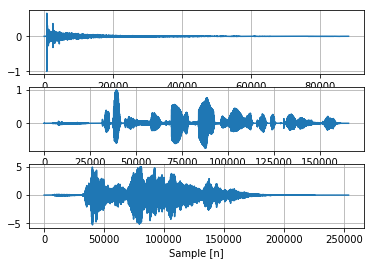

In [22]:
speech_path ="SpeechCorpus/"
rir_path ="RIRcorpus/"
speechFiles = os.listdir(speech_path)
rirFiles = os.listdir(rir_path)

ir_i = thinkdsp.read_wave(rir_path+'classroom_441.wav')
ir_i.normalize()
spd_i = thinkdsp.read_wave(speech_path+speechFiles[0])
spd_i.normalize()
revSpeech = spd_i.convolve(ir_i)

plt.subplot(311)
plt.grid(True)
plt.plot(ir_i.ys)
plt.subplot(312)
plt.plot(spd_i.ys)
plt.grid(True)
plt.subplot(313)
plt.plot(revSpeech.ys)
plt.grid(True)
plt.xlabel('Sample [n]')
plt.show()

# Neural Network

In [ ]:
#---- Hyperparameters
learning_rate = 0.0001
training_iters = 5000#3000000  # steps
batch_size = 64
width = 20  # MFCC features : 
height = 80  # (max) length of utterance
classes = 10  # digits

#Split Data for train and test
batch = word_batch = speech_data_mod.mfcc_batch_generator(batch_size)
X, Y = next(batch)
trainX, trainY = X, Y
testX, testY = X, Y 

In [ ]:
# Network building
net = tflearn.input_data([None, width, height])
net = tflearn.lstm(net, 128, dropout=0.5)	#net = tflearn.lstm(net, 128*4, dropout=0.5)
net = tflearn.fully_connected(net, classes, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=learning_rate, loss='categorical_crossentropy')

In [ ]:
# Training
model = tflearn.DNN(net, tensorboard_verbose=0)

for step in range(0, training_iters):
	print("fitting step:",step)
	trainX, trainY = next(batch)
	testX, testY = next(batch)  # todo: proper ;)	
	model.fit(trainX, trainY, n_epoch=10, validation_set=(testX, testY), show_metric=True, batch_size=batch_size)	


model.save("myASR-model_2") #save model